<a href="https://colab.research.google.com/github/HyVeel/eksploracja-danych/blob/main/zaj12/zad_klasteryzacja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pylcs # dla LSC

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pylcs

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.feature_extraction.text import CountVectorizer

pd.reset_option("display")
pd.options.display.expand_frame_repr = False

## Zadanie 1

### Wczytaj dane z pliku PersonalData.csv.

In [3]:
df = pd.read_csv("PersonalData.csv", index_col=0)
df

,Wzrost (cm),Waga (kg),Staz (lata),Zarobki (tys.),Ocena (pkt.),Piętro,Dzieci,Odleglosc (km),Ubezp.
A,190,88,3,3.5,7,6,1,25,Tak
B,172,70,12,4.3,5,1,4,12,Nie


In [4]:
# Zamiana typu Ubezp. ze str na int
df["Ubezp."] = df["Ubezp."].map({"Tak": 1, "Nie": 0})
df

,Wzrost (cm),Waga (kg),Staz (lata),Zarobki (tys.),Ocena (pkt.),Piętro,Dzieci,Odleglosc (km),Ubezp.
A,190,88,3,3.5,7,6,1,25,1
B,172,70,12,4.3,5,1,4,12,0


### Oblicz odległość euklidesową (d(A, B)) między dwoma wybranymi rekordami (A) i (B).

In [5]:
def get_euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

In [6]:
A = df.loc["A"]
B = df.loc["B"]
d_euclidean = get_euclidean_distance(A, B)

print(f"---d_euclidean:\n{d_euclidean}")

---d_euclidean:
30.620907889871585


### Zmodyfikuj skalę dla atrybutu zarobki (przeskaluj jednostki z tysięcy na złote) i ponownie oblicz odległość euklidesową. Jak zmiana skali wpływa na wynik?

In [7]:
df_scaled = df.copy()
df_scaled["Zarobki (tys.)"] = df_scaled["Zarobki (tys.)"] * 1000
df_scaled.rename(columns={"Zarobki (tys.)": "Zarobki"}, inplace=True)
df_scaled

,Wzrost (cm),Waga (kg),Staz (lata),Zarobki,Ocena (pkt.),Piętro,Dzieci,Odleglosc (km),Ubezp.
A,190,88,3,3500.0,7,6,1,25,1
B,172,70,12,4300.0,5,1,4,12,0


In [8]:
A_scaled = df_scaled.loc["A"]
B_scaled = df_scaled.loc["B"]
d_euclidean_scaled = get_euclidean_distance(A_scaled, B_scaled)

print(f"---d_euclidean_scaled:\n{d_euclidean_scaled}")

---d_euclidean_scaled:
800.5854108088655


Zmiana skali ma ogromny wpływ na wynik. Konieczna tu będzie standaryzacja

### Aby wyeliminować wpływ skali, podziel wartość każdego atrybutu przez jego odchylenie standardowe. Oblicz ponownie odległość euklidesową dla przeskalowanych danych.

In [9]:
columns = df_scaled.columns

for column in columns:
    df_scaled[column] = df_scaled[column] / df_scaled[column].std()

print(f"---df_scaled.describe():\n{df_scaled.describe()}")
df_scaled

---df_scaled.describe():
       Wzrost (cm)  Waga (kg)  Staz (lata)   Zarobki  Ocena (pkt.)    Piętro    Dzieci  Odleglosc (km)    Ubezp.
count     2.000000   2.000000     2.000000  2.000000      2.000000  2.000000  2.000000        2.000000  2.000000
mean     14.220703   6.206826     1.178511  6.894291      4.242641  0.989949  1.178511        2.012535  0.707107
std       1.000000   1.000000     1.000000  1.000000      1.000000  1.000000  1.000000        1.000000  1.000000
min      13.513596   5.499719     0.471405  6.187184      3.535534  0.282843  0.471405        1.305428  0.000000
25%      13.867150   5.853273     0.824958  6.540738      3.889087  0.636396  0.824958        1.658981  0.353553
50%      14.220703   6.206826     1.178511  6.894291      4.242641  0.989949  1.178511        2.012535  0.707107
75%      14.574256   6.560380     1.532065  7.247845      4.596194  1.343503  1.532065        2.366088  1.060660
max      14.927810   6.913933     1.885618  7.601398      4.949747  1.6

,Wzrost (cm),Waga (kg),Staz (lata),Zarobki,Ocena (pkt.),Piętro,Dzieci,Odleglosc (km),Ubezp.
A,14.927810,6.913933,0.471405,6.187184,4.949747,1.697056,0.471405,2.719641,1.414214
B,13.513596,5.499719,1.885618,7.601398,3.535534,0.282843,1.885618,1.305428,0.000000


### Dla punktów (A) i (B) oblicz także odległość Minkowskiego oraz odległość miejską (Manhattan).

In [10]:
d_manhattan = np.sum(np.abs(A - B))
p = 3
d_minkowski = np.sum(np.abs(A - B) ** p) ** (1 / p)

print(f"---d_manhattan:\n{d_manhattan}")
print(f"---d_minkowski(p={p}):\n{d_minkowski}")

---d_manhattan:
69.8
---d_minkowski(p=3):
24.52517861323848


## Zadanie 2

Napisz program pozwalający obliczać podobieństwo między sekwencjami DNA traktowanymi jako ciągi znaków.

Zaimplementować na podstawie metryki
$$
D(x, y) = |x| + |y| - 2|LCS(x,y)|
$$

gdzie LCS oznacza najdłuszą wspólna podsekwencję (ang.
longest common subsequence)
  
  (LCS(x,y) = bcde). D(x, y) = 3

In [11]:
def get_D_x_y(x, y):
    lcs_len = pylcs.lcs(x, y)
    # print(f"---lcs_len:\n{lcs_len}")

    return len(x) + len(y) - 2 * lcs_len

In [12]:
x = "abcde"
y = "bcdxye"
print(f"---get_similarity:\n{get_D_x_y(x, y)}") # Oczekiwany wynik 3

X = "AGGTAB"
Y = "GXTXAYB"
print(f"---get_similarity:\n{get_D_x_y(X, Y)}") # Oczekiwany wynik 5

---get_similarity:
3
---get_similarity:
5


## Zadanie 3

Masz opisy trzech filmów
- `film1 = "kosmiczna stacja astronauta planeta obca"`
- `film2 = "astronauta rakieta księżyc misja kosmiczna"`
- `film3 = "wampir zamek noc krew mroczny"`

In [13]:
film1 = "kosmiczna stacja astronauta planeta obca planeta"
film2 = "astronauta rakieta księżyc misja kosmiczna"
film3 = "wampir zamek noc krew mroczny"

### a. Stwórz reprezentację wektorową dla każdego filmu używając CountVectorizer

In [14]:
documents = [film1, film2, film3]
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(documents).toarray()

print("Słownik:", vectorizer.get_feature_names_out())
print("\nWektory dokumentów:")

for document, vector in zip(documents, vectors):
    print(f"{document}:\n{vector}\n")

Słownik: ['astronauta' 'kosmiczna' 'krew' 'księżyc' 'misja' 'mroczny' 'noc' 'obca'
 'planeta' 'rakieta' 'stacja' 'wampir' 'zamek']

Wektory dokumentów:
kosmiczna stacja astronauta planeta obca planeta:
[1 1 0 0 0 0 0 1 2 0 1 0 0]

astronauta rakieta księżyc misja kosmiczna:
[1 1 0 1 1 0 0 0 0 1 0 0 0]

wampir zamek noc krew mroczny:
[0 0 1 0 0 1 1 0 0 0 0 1 1]



### b. Oblicz podobieństwo cosinusowe między wszystkimi parami filmów

In [15]:
document_count = len(documents)
similarity_matrix = np.zeros((document_count, document_count))

for i in range(document_count):
    for j in range(document_count):
        vector1 = vectors[i]
        vector2 = vectors[j]
        dot_product = np.dot(vector1, vector2)
        norm_vector1 = np.linalg.norm(vector1)
        norm_vector2 = np.linalg.norm(vector2)
        similarity = dot_product / (norm_vector1 * norm_vector2)
        similarity_matrix[i, j] = similarity

similarity_matrix_df = pd.DataFrame(similarity_matrix, columns=documents, index=documents)

print("Macierz podobieństw cosinusowych:")
similarity_matrix_df

Macierz podobieństw cosinusowych:


,kosmiczna stacja astronauta planeta obca planeta,astronauta rakieta księżyc misja kosmiczna,wampir zamek noc krew mroczny
kosmiczna stacja astronauta planeta obca planeta,1.000000,0.316228,0.0
astronauta rakieta księżyc misja kosmiczna,0.316228,1.000000,0.0
wampir zamek noc krew mroczny,0.000000,0.000000,1.0


### c. Które dwa filmy są najbardziej podobne? Które najmniej?

- Najbardziej podobne do siebie filmy (nie wliczając samych siebie) są: **film1** z **film2**
- Najmniej podobne do siebie są: **film1** z **film3** oraz **film2** z **film3**

### d . Dodaj czwarty film i sprawdź do którego jest najbardziej podobny:
    `film4 = "rakieta mars astronauta czerwona planeta"`

In [16]:
film4 = "rakieta mars astronauta czerwona planeta"
film4_vector = vectorizer.transform([film4]).toarray()[0]
print(f"---film4_vector:\n{film4_vector}")

similarities_to_film4 = []

for i in range(document_count):
    vector1 = film4_vector
    vector2 = vectors[i]
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)
    similarity = dot_product / (norm_vector1 * norm_vector2)
    similarities_to_film4.append(similarity)

similarities_to_film4_df = pd.DataFrame(similarities_to_film4, columns=[film4], index=documents)

print("\nMacierz podobieństw cosinusowych do film4:")
similarities_to_film4_df

---film4_vector:
[1 0 0 0 0 0 0 0 1 1 0 0 0]

Macierz podobieństw cosinusowych do film4:


,rakieta mars astronauta czerwona planeta
kosmiczna stacja astronauta planeta obca planeta,0.612372
astronauta rakieta księżyc misja kosmiczna,0.516398
wampir zamek noc krew mroczny,0.000000


- **Film4** najbardziej podobny jest do **film1**

## Zadanie 4

### A. Wczytaj dane z pliku **k_means_data.csv.**

In [17]:
data = pd.read_csv("k_means_data.csv")

print(f"---data.shape:\n{data.shape}")
print(f"\n---data.describe():\n{data.describe()}")
print(f"\n---data.head():\n{data.head()}")

---data.shape:
(80, 2)

---data.describe():
              X1         X2
count  80.000000  80.000000
mean    0.494738   2.828920
std     1.641679   1.472838
min    -2.421659  -0.138106
25%    -1.164080   1.518663
50%     0.981543   3.138834
75%     1.737607   4.078237
max     3.209033   5.474253

---data.head():
         X1        X2
0  2.131415  1.138857
1  2.161723  0.656595
2  1.062696  5.176351
3  1.807096  0.449191
4  2.269087  1.321608


### B. Zastosuj **algorytm hierarchiczny aglomeracyjny** i wyszukaj w zbiorze danych klastry.

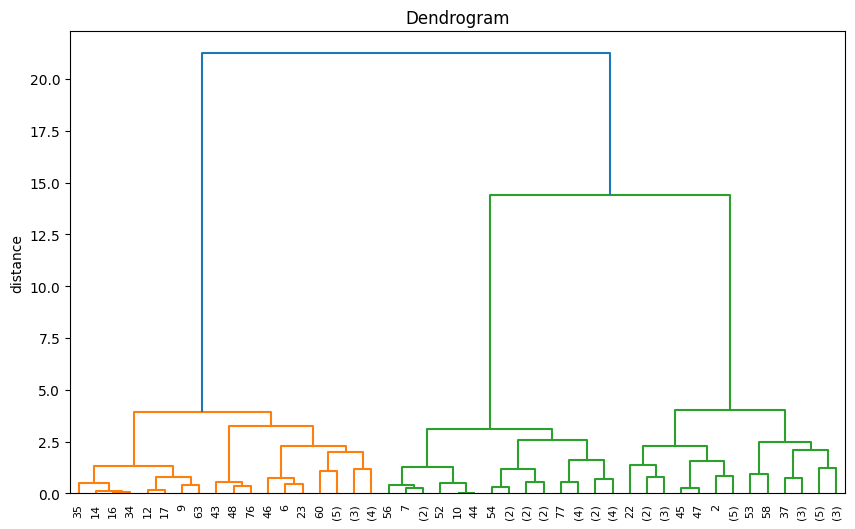

In [19]:
Z = linkage(data, method="ward")

fix, ax = plt.subplots(figsize=(10, 6))
dendrogram(Z, truncate_mode="level", p=5, show_leaf_counts=True)
plt.title("Dendrogram")
ax.set_ylabel("distance")
plt.show()

In [20]:
k = 3
agg_clustering_model = AgglomerativeClustering(n_clusters=k, linkage="ward")
agg_clustering_model.fit(data)

data["agg_cluster"] = agg_clustering_model.labels_
data.head()

,X1,X2,agg_cluster
0,2.131415,1.138857,1
1,2.161723,0.656595,1
2,1.062696,5.176351,0
3,1.807096,0.449191,1
4,2.269087,1.321608,1


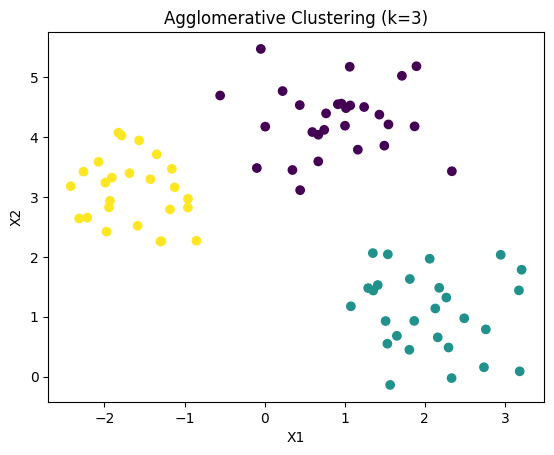

In [21]:
plt.scatter(data["X1"], data["X2"], c=data["agg_cluster"])
plt.xlabel("X1")
plt.ylabel("X2")
plt.title(f"Agglomerative Clustering (k={k})")
plt.show()

### C. Zastosuj **algorytm k-średnich** i wyszukaj w zbiorze danych klastry

In [22]:
k = 3
kmeans_model = KMeans(n_clusters=k)
kmeans_model.fit(data)

centers = kmeans_model.cluster_centers_
data["kmeans_cluster"] = kmeans_model.labels_
data.head()

,X1,X2,agg_cluster,kmeans_cluster
0,2.131415,1.138857,1,1
1,2.161723,0.656595,1,1
2,1.062696,5.176351,0,0
3,1.807096,0.449191,1,1
4,2.269087,1.321608,1,1


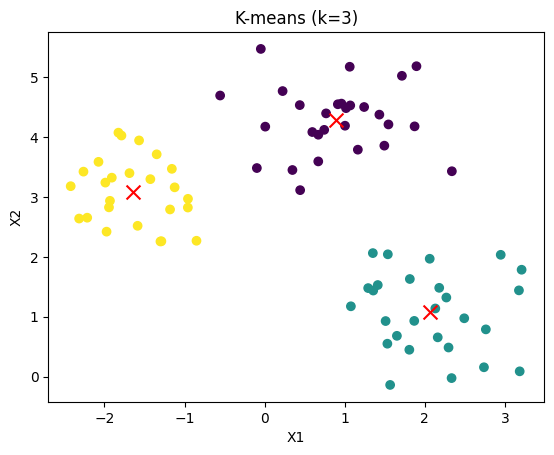

In [23]:
plt.scatter(data["X1"], data["X2"], c=data["kmeans_cluster"])
plt.scatter(centers[:, 0], centers[:, 1], marker="x", color="red", s=100)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title(f"K-means (k={k})")
plt.show()

## Zadanie 5

Zaimplementuj samodzielnie **algorytm k-średnich** dla danych z pliku **k_means_data.csv**.

In [24]:
def manual_kmeans(data_df, n_clusters):
    points_df = data_df.copy()
    points_df.columns = ["x", "y"]
    centroids = points_df.sample(n=n_clusters).values
    cluster_labels = []
    iterations = 0

    while True:
        iterations += 1
        new_cluster_labels = []

        for point in points_df[["x", "y"]].values:
            point = np.array(point)
            distances = []

            for centroid in centroids:
                centroid = np.array(centroid)
                distance = get_euclidean_distance(point, centroid)
                distances.append(distance)

            shortest_distance = min(distances)
            shortest_distance_index = distances.index(shortest_distance)
            new_cluster_labels.append(shortest_distance_index)

        if new_cluster_labels == cluster_labels:
            return {
                "centroids": centroids,
                "cluster_labels": cluster_labels,
                "iterations": iterations
            }

        cluster_labels = new_cluster_labels
        points_df["cluster"] = cluster_labels
        centroids = []

        for i in range(n_clusters):
            cluster_points = points_df[points_df["cluster"] == i]
            new_centroid_x = cluster_points["x"].mean()
            new_centroid_y = cluster_points["y"].mean()
            new_centroid = [new_centroid_x, new_centroid_y]

            centroids.append(new_centroid)

        centroids = np.array(centroids)

In [25]:
k = 3
manual_kmeans_result = manual_kmeans(data[["X1", "X2"]], n_clusters=k)
manual_cluster_labels = manual_kmeans_result["cluster_labels"]
manual_centers = manual_kmeans_result["centroids"]
manual_iterations = manual_kmeans_result["iterations"]

data["manual_kmeans_cluster"] = manual_cluster_labels

print(f"\n---manual_centers:\n{manual_centers}")
print(f"\n---manual_iterations:\n{manual_iterations}")
print(f"\n---data.head():\n{data.head()}")


---manual_centers:
[[-1.64346181  3.08940684]
 [ 0.89061308  4.28598166]
 [ 2.06401581  1.07670184]]

---manual_iterations:
3

---data.head():
         X1        X2  agg_cluster  kmeans_cluster  manual_kmeans_cluster
0  2.131415  1.138857            1               1                      2
1  2.161723  0.656595            1               1                      2
2  1.062696  5.176351            0               0                      1
3  1.807096  0.449191            1               1                      2
4  2.269087  1.321608            1               1                      2


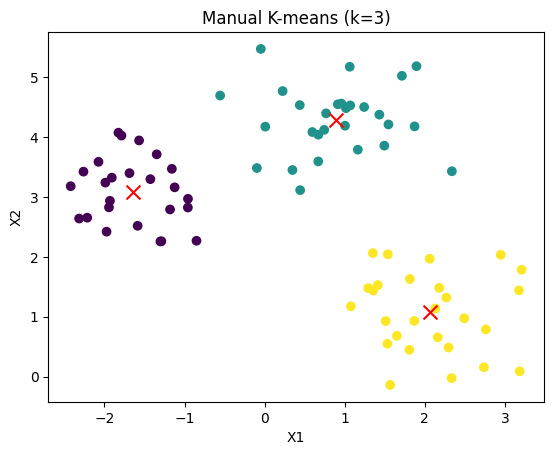

In [26]:
plt.scatter(data["X1"], data["X2"], c=data["manual_kmeans_cluster"])
plt.scatter(manual_centers[:, 0], manual_centers[:, 1], marker="x", color="red", s=100)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title(f"Manual K-means (k={k})")
plt.show()

## Zadanie 6

### 1. Załaduj zbiór danych **iris**. Opis zbioru: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

In [27]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df["species"] = iris.target
species_names = iris.target_names

iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### 2. Narysuj wykres rozrzutu dla współrzędnych **sepal_length** i **sepal_width**. Oznacz różnymi kolorami i markerami różne klasy kwiatów

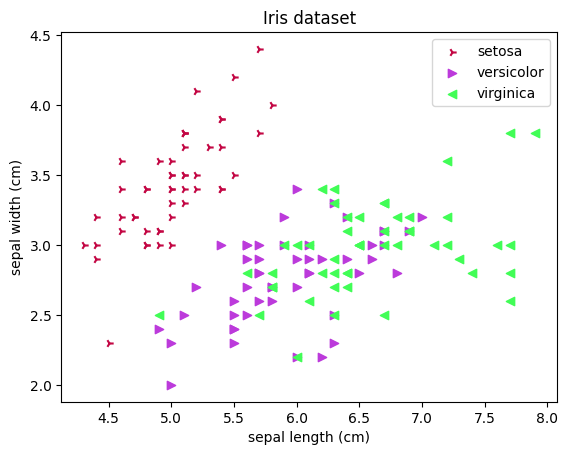

In [28]:
for i, species_name in enumerate(species_names):
    species_df = iris_df[iris_df["species"] == i]

    # Uniwersalne pod dowolną liczbę klas
    color = np.random.rand(3)
    marker = ["o", "s", "D", "v", "^", "<", ">", "1", "2", "3", "4"].pop(np.random.randint(0, 11))

    plt.scatter(species_df["sepal length (cm)"], species_df["sepal width (cm)"], color=color, marker=marker, label=species_name)

plt.legend()
plt.xlabel("sepal length (cm)")
plt.ylabel("sepal width (cm)")
plt.title("Iris dataset")
plt.show()

### 3. Znajdź wartości **minimalne, maksymalne** oraz **średnie odchylenie kwadratowe** dla atrybutów zbioru

In [29]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


### 4. Policz **współczynniki korelacji** między atrybutami

In [30]:
iris_df.corr()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
sepal length (cm),1.000000,-0.117570,0.871754,0.817941,0.782561
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126,-0.426658
petal length (cm),0.871754,-0.428440,1.000000,0.962865,0.949035
petal width (cm),0.817941,-0.366126,0.962865,1.000000,0.956547
species,0.782561,-0.426658,0.949035,0.956547,1.000000


### 5. Zastosuj **algorytm k-średnich** i znajdź podział na klastry dla współrzędnych **sepal_length** i **sepal_width**

In [31]:
k = 3
iris_kmeans_model = KMeans(n_clusters=k)
iris_kmeans_model.fit(iris_df[["sepal length (cm)", "sepal width (cm)"]])

iris_df["kmeans_cluster"] = iris_kmeans_model.labels_
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,kmeans_cluster
0,5.1,3.5,1.4,0.2,0,0
1,4.9,3.0,1.4,0.2,0,0
2,4.7,3.2,1.3,0.2,0,0
3,4.6,3.1,1.5,0.2,0,0
4,5.0,3.6,1.4,0.2,0,0


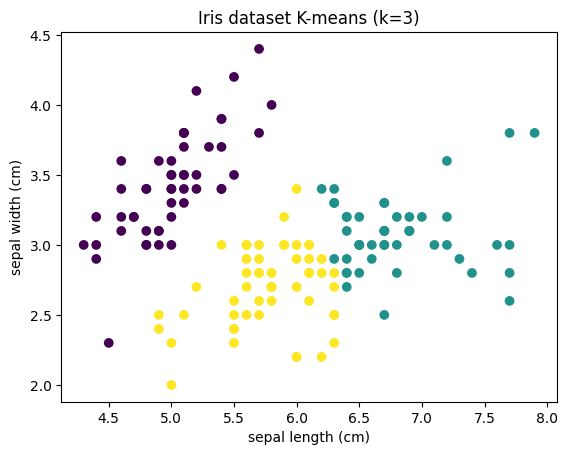

In [32]:
plt.scatter(iris_df["sepal length (cm)"], iris_df["sepal width (cm)"], c=iris_df["kmeans_cluster"])
plt.xlabel("sepal length (cm)")
plt.ylabel("sepal width (cm)")
plt.title(f"Iris dataset K-means (k={k})")
plt.show()

### 6. Zastosuj **algorytm hierarchiczny aglomeracyjny** i znajdź podział na klastry dla współrzędnych **sepal_length** i **sepal_width**

In [33]:
k = 3
iris_agg_cluster_model = AgglomerativeClustering(n_clusters=k, linkage="ward")
iris_agg_cluster_model.fit(iris_df)

iris_df["agg_cluster"] = iris_agg_cluster_model.labels_
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,kmeans_cluster,agg_cluster
0,5.1,3.5,1.4,0.2,0,0,1
1,4.9,3.0,1.4,0.2,0,0,1
2,4.7,3.2,1.3,0.2,0,0,1
3,4.6,3.1,1.5,0.2,0,0,1
4,5.0,3.6,1.4,0.2,0,0,1


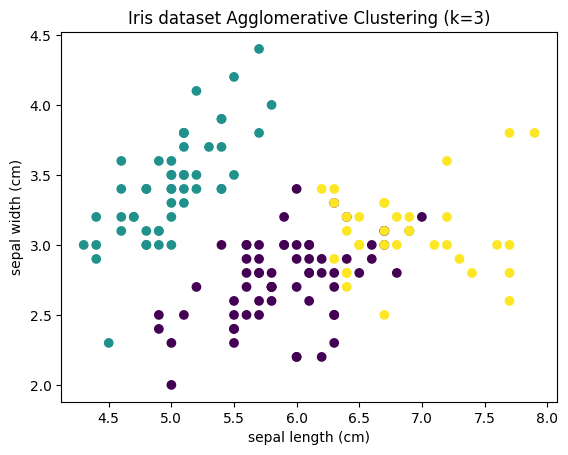

In [34]:
plt.scatter(iris_df["sepal length (cm)"], iris_df["sepal width (cm)"], c=iris_df["agg_cluster"])
plt.xlabel("sepal length (cm)")
plt.ylabel("sepal width (cm)")
plt.title(f"Iris dataset Agglomerative Clustering (k={k})")
plt.show()

## Zadanie 7
###Dla danych z pliku penguins.csv wykonaj polecenia.
W **punktach 3-5** przetestuj różne sposoby obliczenia odległości między klastrami (linkage-complete, average, single, ward).

Dane z https://github.com/mwaskom/seaborn-data/blob/master/penguins.csv

### 0. Wyświetl podstawowe informacje o zbiorze

In [35]:
penguins_df = pd.read_csv("penguins.csv")

print(f"---penguins_df.shape:\n{penguins_df.shape}")
print(f"\n---penguins_df.head():\n{penguins_df.head()}")
print(f"\n---penguins_df.describe():\n{penguins_df.describe()}")
print(f"\n---penguins_df.info():\n{penguins_df.info()}")

---penguins_df.shape:
(344, 7)

---penguins_df.head():
  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g     sex
0  Adelie  Torgersen            39.1           18.7              181.0       3750.0    MALE
1  Adelie  Torgersen            39.5           17.4              186.0       3800.0  FEMALE
2  Adelie  Torgersen            40.3           18.0              195.0       3250.0  FEMALE
3  Adelie  Torgersen             NaN            NaN                NaN          NaN     NaN
4  Adelie  Torgersen            36.7           19.3              193.0       3450.0  FEMALE

---penguins_df.describe():
       bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
count      342.000000     342.000000         342.000000   342.000000
mean        43.921930      17.151170         200.915205  4201.754386
std          5.459584       1.974793          14.061714   801.954536
min         32.100000      13.100000         172.000000  2700.000000
25%         39.22500

### 1. Sprawdź czy w zbiorze nie brakuje danych. Jeżeli są - usuń je

In [36]:
print(f"\n---penguins_df.isna().sum():\n{penguins_df.isna().sum()}")
penguins_df.dropna(inplace=True)
print(f"---penguins_df.shape:\n{penguins_df.shape}")


---penguins_df.isna().sum():
species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64
---penguins_df.shape:
(333, 7)


### 2. Ogranicz się do atrybutów **bill_length_mm** i **flipper_length_mm**

In [37]:
penguins_df = penguins_df[["bill_length_mm", "flipper_length_mm"]]

### 3. Narysuj dendogram, zinterpretuj go i wyznacz ilość klastrów

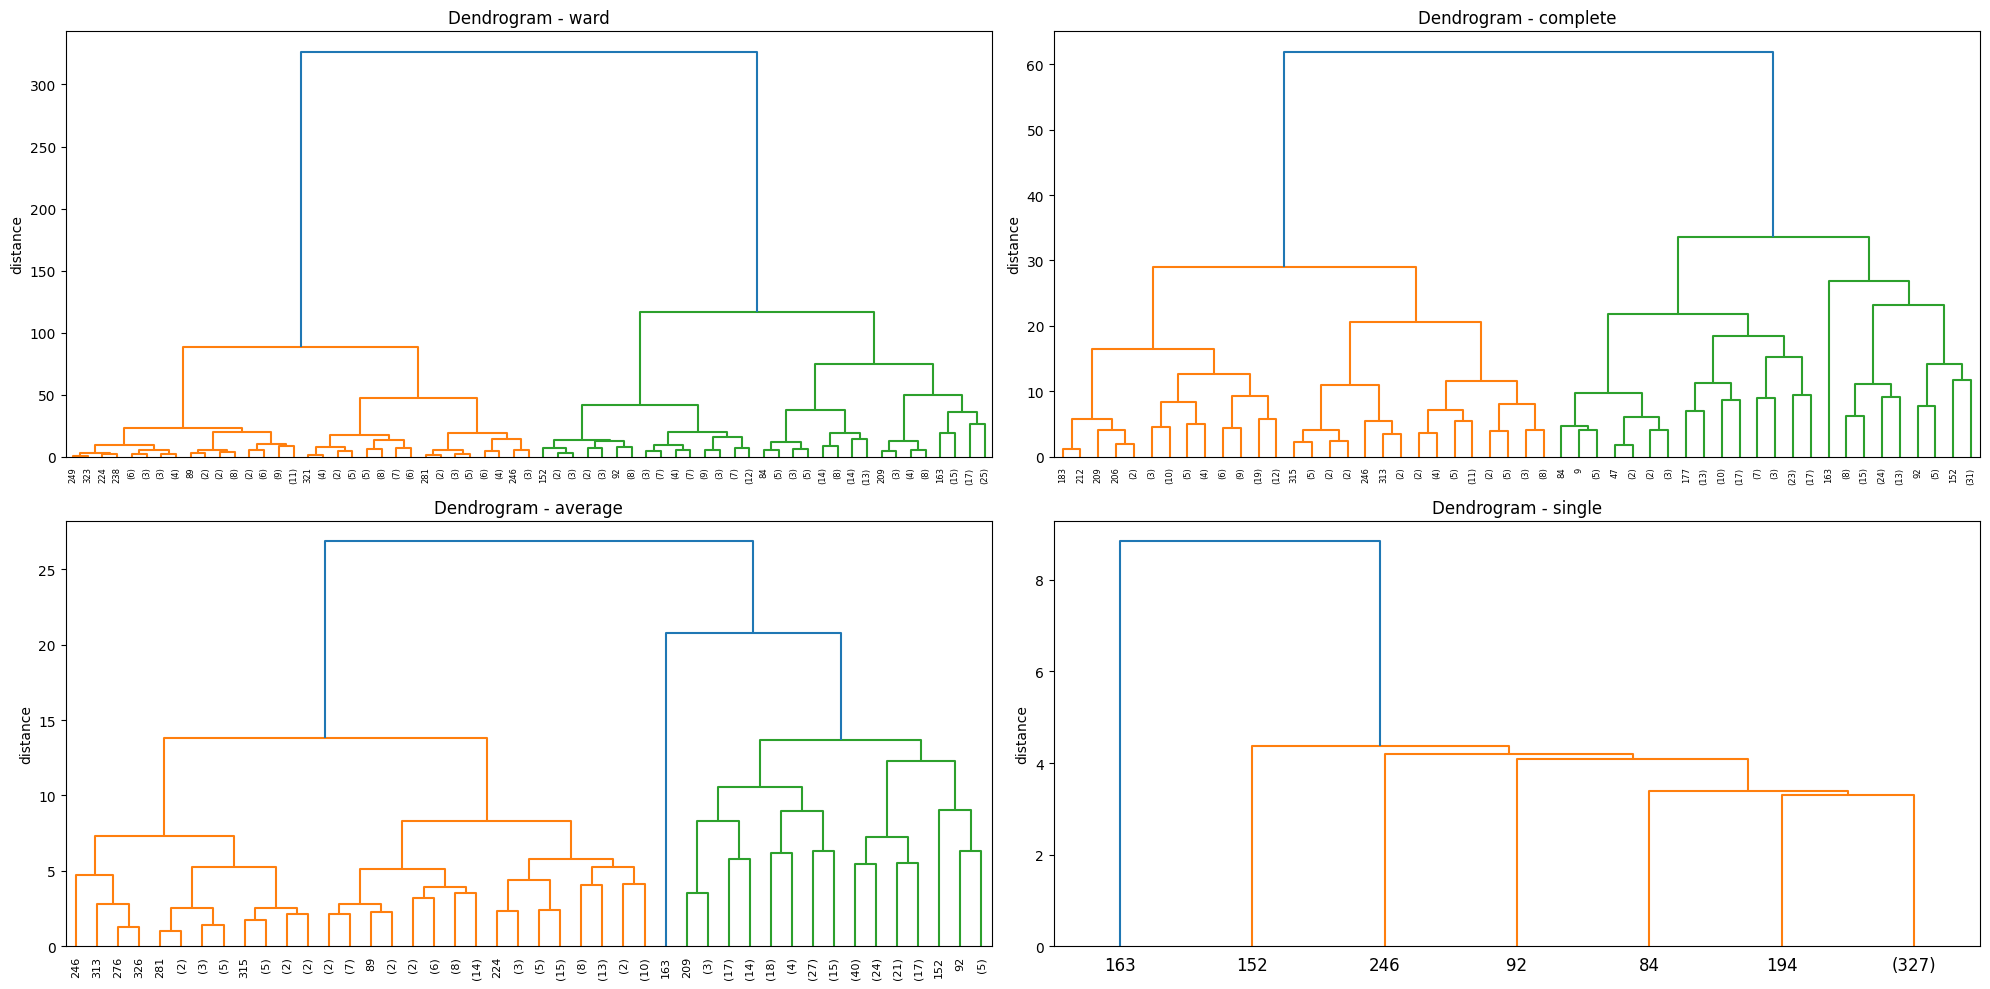

In [38]:
fix, axes = plt.subplots(2, 2, figsize=(20, 10))

methods = ["ward", "complete", "average", "single"]

for ax, method in zip(axes.flatten(), methods):
    linked = linkage(penguins_df, method=method)
    dendrogram(linked, ax=ax, truncate_mode="level", p=5, show_leaf_counts=True)
    ax.set_ylabel("distance")
    ax.set_title(f"Dendrogram - {method}")

plt.tight_layout()
plt.show()

Wyznaczam ilość klastrów indywidualnie dla każdej metody

### 4. Zastosuj algorytm hierarchiczny aglomeracyjny do zbioru i wyznacz klastry

In [39]:
method_ks = [5, 4, 6, 2]
method_clusters = []

for method, k in zip(methods, method_ks):
    penguins_agg_cluster_model = AgglomerativeClustering(n_clusters=k, linkage=method)
    penguins_agg_cluster_model.fit(penguins_df)
    clusters = penguins_agg_cluster_model.labels_
    method_clusters.append(clusters)

### 5. Stwórz wykres rozrzutu z zaznaczonymi klastrami

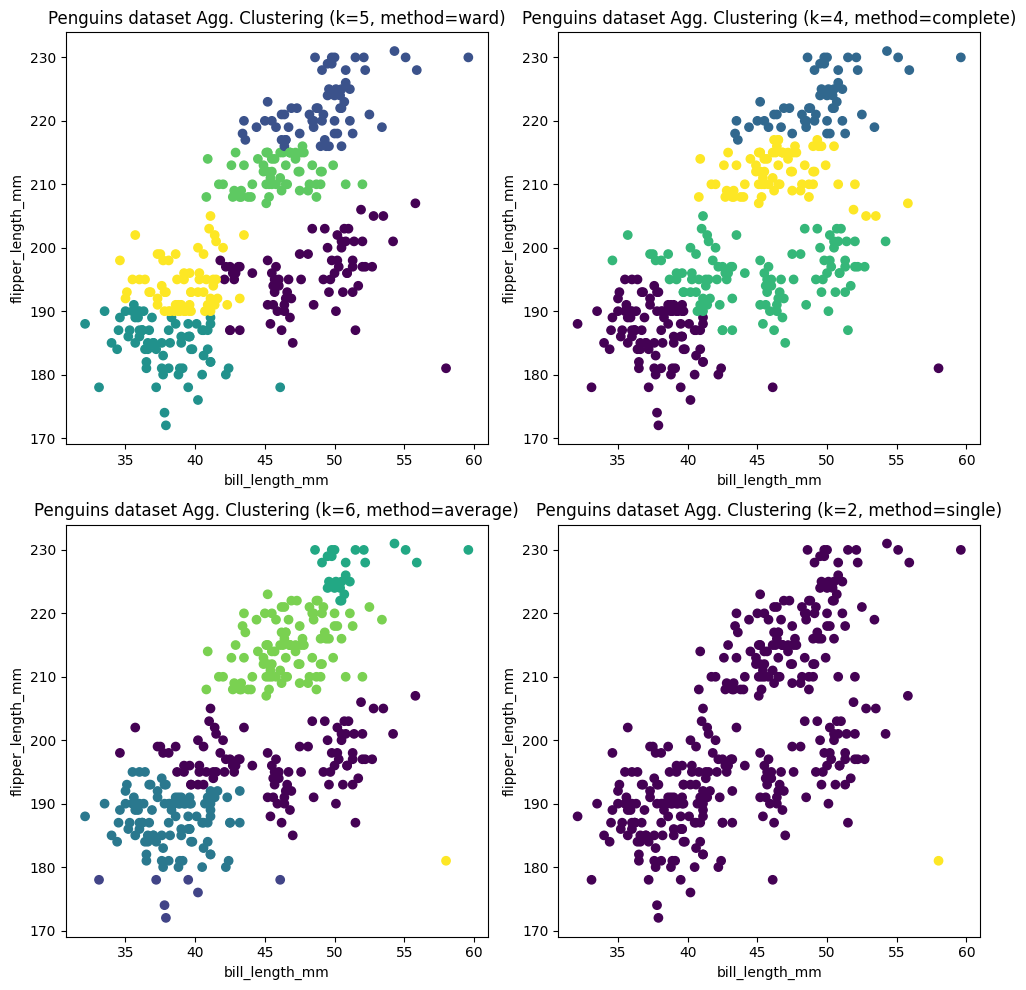

In [40]:
fix, axes = plt.subplots(2, 2, figsize=(10, 10))

for ax, method, clusters, k in zip(axes.flatten(), methods, method_clusters, method_ks):
    ax.scatter(penguins_df["bill_length_mm"], penguins_df["flipper_length_mm"], c=clusters)
    ax.set_xlabel("bill_length_mm")
    ax.set_ylabel("flipper_length_mm")
    ax.set_title(f"Penguins dataset Agg. Clustering (k={k}, method={method})")

plt.tight_layout()
plt.show()